In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='darkgrid', font_scale=1.25)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('US2020air.csv', error_bad_lines=False)
df2 = pd.read_csv('statewide_cases.csv', error_bad_lines=False)
CO = pd.read_csv('CO_2020.csv')
SO2 = pd.read_csv('SO2_2020.csv')
NO2 = pd.read_csv('NO2_2020.csv')
O3 = pd.read_csv('O3_2020.csv')

In [3]:
def plot_pollutant_trend(data, factor, county='San Diego', window=30):
    '''
    Plot line plots based on the moving average of given data.
    :param data: full dataset of air pollutant in the US
    :param city: city name from available cities in the dataset
    :param factor: pollutant to observe
    :param window: size of the moving average window
    :type data: pandas DataFrame
    :type county: str
    :type factor: str
    :type window: int
    :returns: None
    '''
    assert isinstance(data, pd.DataFrame), 'data must be in pandas DataFrame'
    assert isinstance(county, str) and county in data['County Name'].unique(), 'county must be a string from available counties'
    assert isinstance(factor, str), 'factor must be a string'
    assert isinstance(window, int) and window > 0, 'window must be a positive integer'
    
    # prepare data
    data = data.loc[data['County Name'] == county]
    data['Date'] = pd.to_datetime(data['Date Local'])
    data['Moving Average'] = data['Arithmetic Mean'].rolling(window=window, center=True).mean()
    data = data[data['Moving Average'].notna()]
    data = data.sort_values(by='Date')
    
    # line plot
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    title = '{} vs COVID19 Cases {}-Day Moving Average'.format(factor.upper(), window)
    sns.lineplot(data=data, x='Date', y='Moving Average', ax=ax1, color='b', label='{}'.format(factor.upper())).set_title(title)
    sns.lineplot(data=covid, x='date', y='totalcountconfirmed', ax=ax2, color='r', label='COVID19')
    ax1.set_ylabel('{} Emission (ppm)'.format(factor.upper()))
    ax2.set_ylabel('COVID-19 Confirmed Cases')
    fig.legend(loc='lower right', bbox_to_anchor=(0.83, 0.125))
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    plt.show()

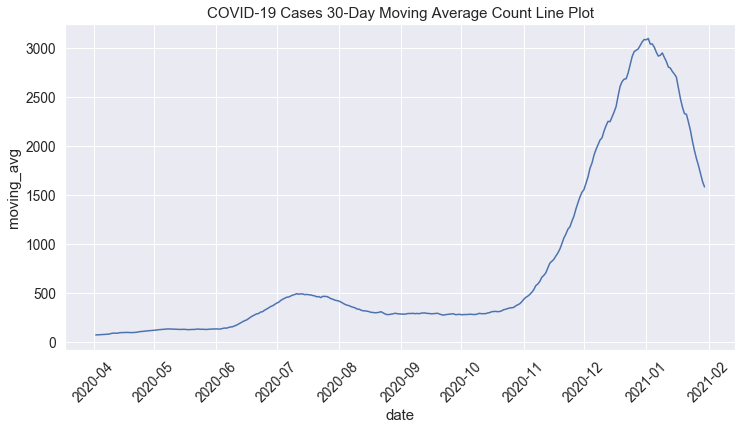

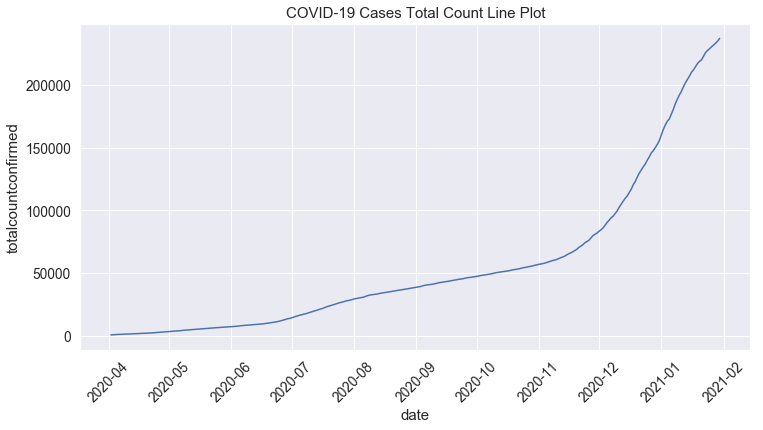

In [4]:
covid = df2.loc[df2['county'] == 'San Diego']
covid['date'] = pd.to_datetime(covid['date'])
covid = covid.sort_values(by='date')
covid['moving_avg'] = covid['newcountconfirmed'].rolling(window=30, center=True).mean()
covid.dropna(inplace=True)
covid = covid.sort_values(by='date')
covid['date_index'] = range(0, len(covid))

# line plot
plt.figure(figsize=(12,6))
title = 'COVID-19 Cases {}-Day Moving Average Count Line Plot'.format(30)
sns.lineplot(data=covid, x='date', y='moving_avg').set_title(title)
plt.xticks(rotation=45)
plt.show()

# line plot
plt.figure(figsize=(12,6))
title = 'COVID-19 Cases Total Count Line Plot'
sns.lineplot(data=covid, x='date', y='totalcountconfirmed').set_title(title)
plt.xticks(rotation=45)
plt.show()

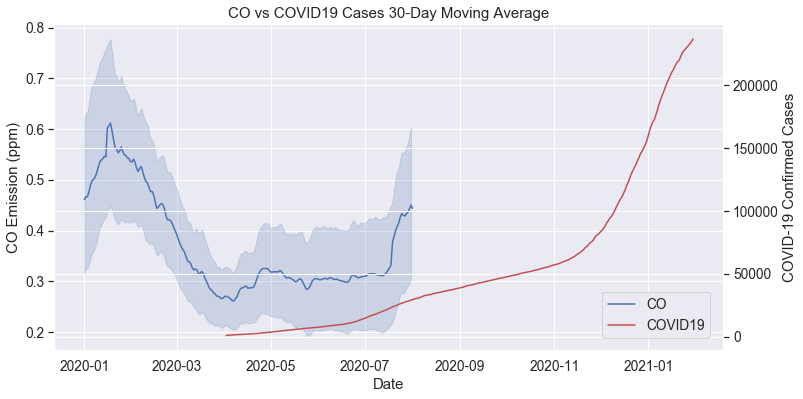

In [5]:
plot_pollutant_trend(CO, 'CO', 'San Diego', 30)

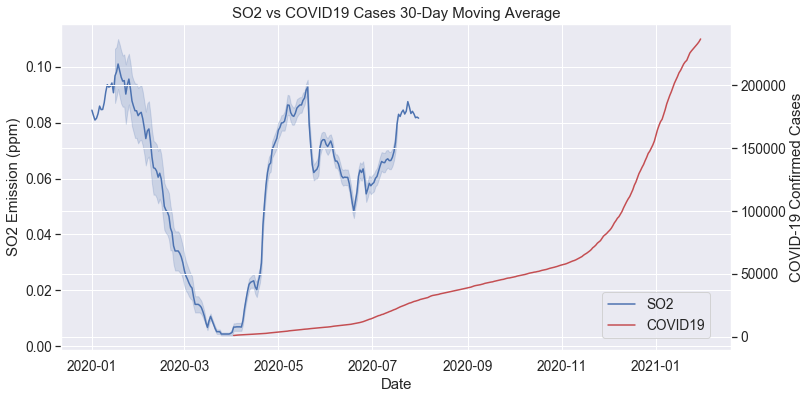

In [6]:
plot_pollutant_trend(SO2, 'SO2', 'San Diego', 30)

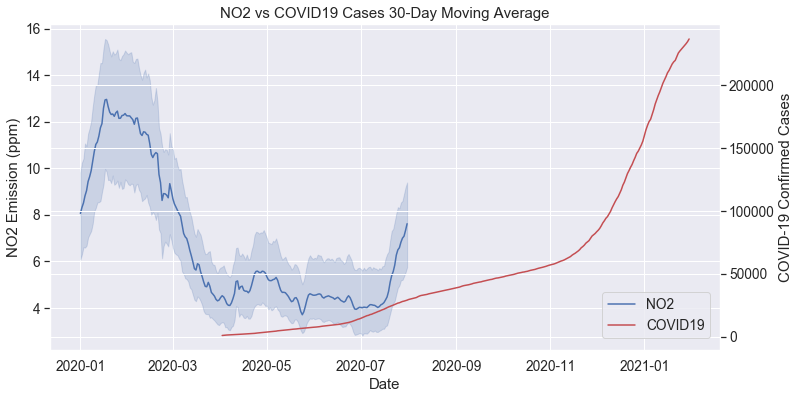

In [7]:
plot_pollutant_trend(NO2, 'NO2', 'San Diego', 30)

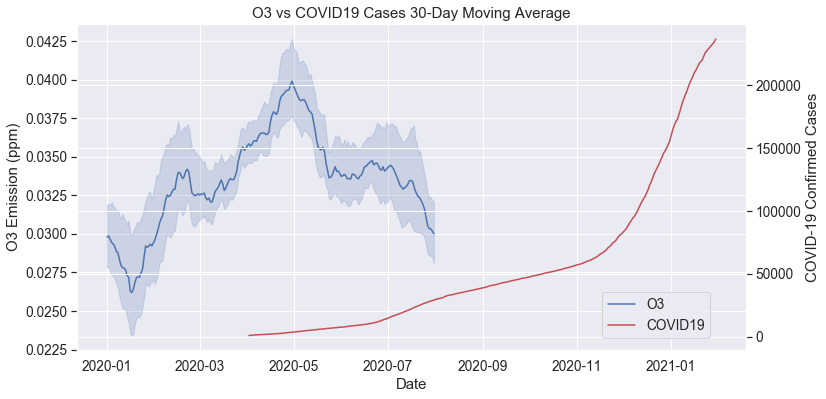

In [8]:
plot_pollutant_trend(O3, 'O3', 'San Diego', 30)

In [9]:
def plot_pollutants_trend(data, city='San Diego', factor='co', window=30):
    '''
    Plot a line plot and a third order regression plot based on the moving average of given data.
    :param data: full dataset on US air quality
    :param city: city name from available cities in the dataset
    :param factor: pollutant to observe
    :param window: size of the moving average window
    :type data: pandas DataFrame
    :type city: str
    :type factor: str
    :type window: int
    :returns: None
    '''
    assert isinstance(data, pd.DataFrame), 'data must be in pandas DataFrame'
    assert isinstance(city, str) and city in data['City'].unique(), 'city must be a string from available cities'
    assert isinstance(factor, str) and factor in data['Specie'].unique(), 'factor must be a string from available species'
    assert isinstance(window, int) and window > 0, 'window must be a positive integer'
    
    # prepare data
    data = data.loc[data['City'] == city]
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.loc[data['Specie'] == factor].sort_values(by='Date')
    data['moving_avg'] = data['median'].rolling(window=window, center=True).mean()
    data.dropna(inplace=True)
    data = data.sort_values(by='Date')
    data['date_index'] = range(0, len(data))
    
    # line plot
    plt.figure(figsize=(12,6))
    title = '{} {}-Day Moving Average Line Plot'.format(factor.upper(), window)
    sns.lineplot(data=data, x='date_index', y='moving_avg').set_title(title)
    plt.xticks(rotation=45)
    plt.show()
    
    # regression plot
    plt.figure(figsize=(12,6))
    title = '{} {}-Day Moving Average Line Plot'.format(factor.upper(), window)
    sns.regplot(data=data, x='date_index', y='moving_avg', order=3).set_title(title)
    plt.xticks(rotation=45)
    plt.show()

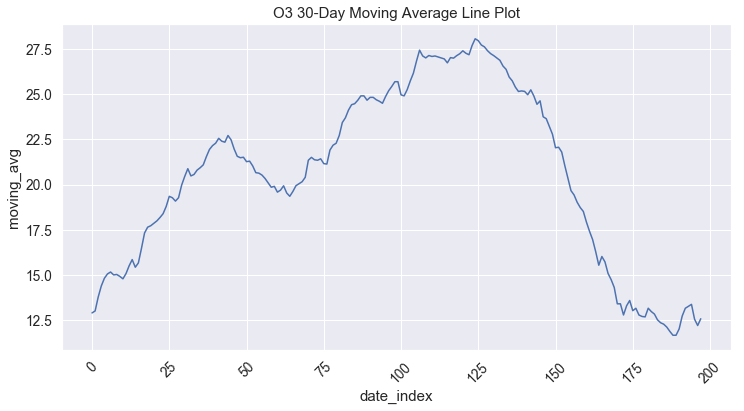

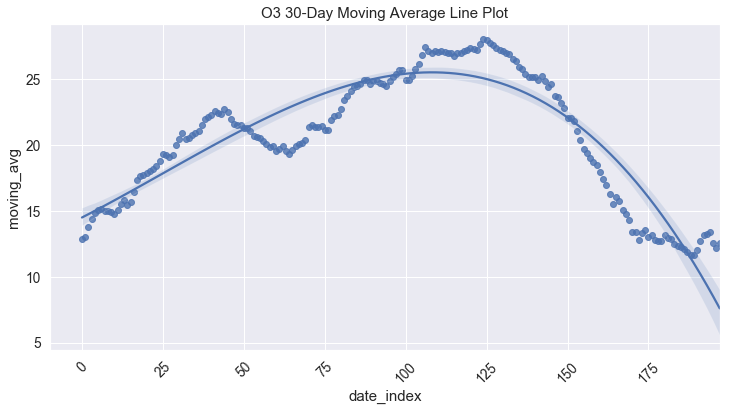

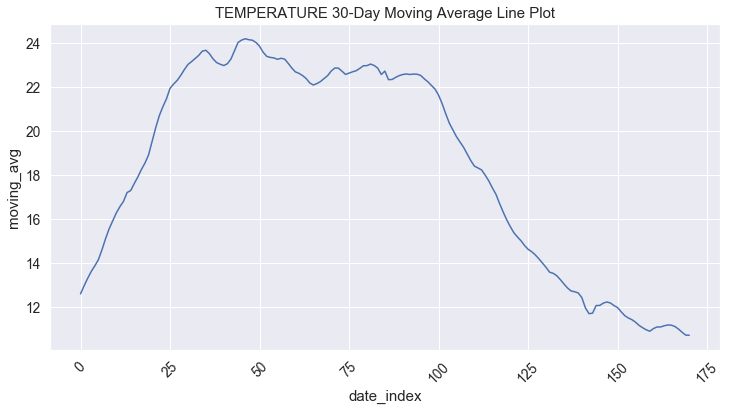

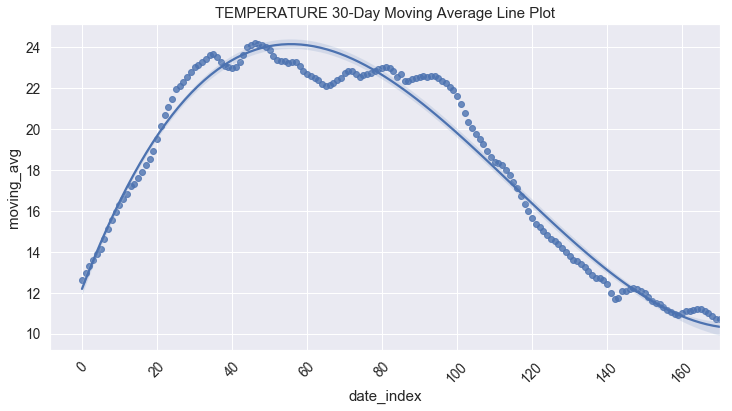

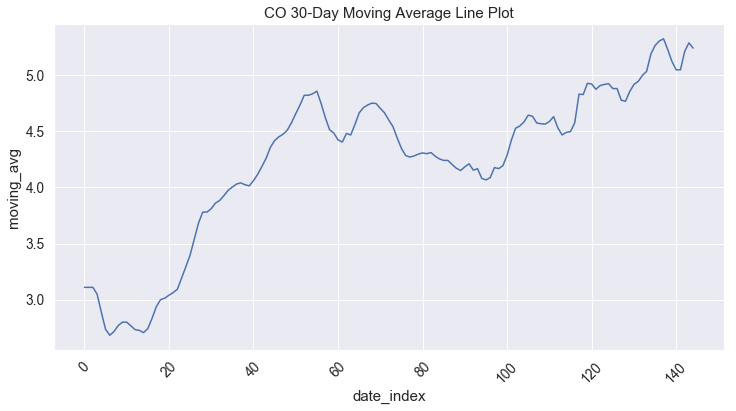

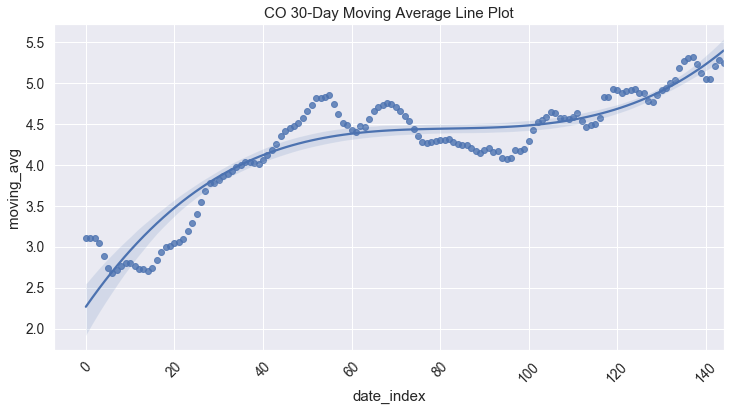

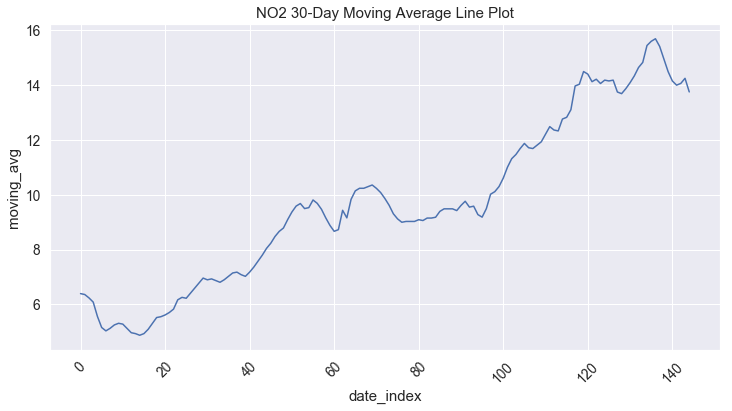

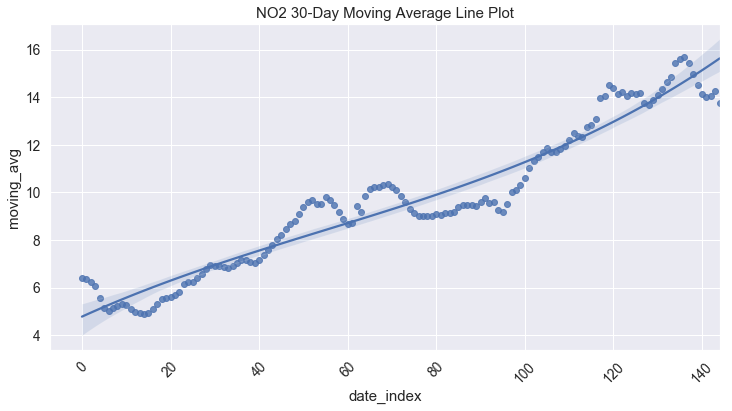

In [10]:
for f in ['o3', 'temperature', 'co', 'no2']:
    plot_pollutants_trend(df, factor=f)

In [15]:
la = df.loc[df['City'] == 'Los Angeles']
la

,Date,Country,City,Specie,count,min,max,median,variance
23746,1/10/20,US,Los Angeles,so2,3,1.5,1.5,1.5,0.00
23747,1/3/20,US,Los Angeles,so2,3,1.5,1.5,1.5,0.00
23748,1/9/20,US,Los Angeles,so2,3,1.5,1.5,1.5,0.00
23749,2/28/20,US,Los Angeles,so2,4,1.5,2.9,1.5,4.90
23750,1/2/20,US,Los Angeles,so2,9,1.5,1.5,1.5,0.00
...,...,...,...,...,...,...,...,...,...
186322,12/9/20,US,Los Angeles,o3,16,0.2,32.8,6.4,1738.04
186323,12/29/20,US,Los Angeles,o3,22,0.8,31.2,4.0,1197.34
186324,12/31/20,US,Los Angeles,o3,19,0.8,32.0,22.4,1451.55
186325,10/3/20,US,Los Angeles,o3,28,0.8,117.3,12.1,15599.50


In [20]:
test_la = la.loc[la['Specie'] == 'co']
test_la['Date'] = pd.to_datetime(test_la['Date'])
test_la = test_la.sort_values(by='Date')
test_la['moving_avg'] = test_la['median'].rolling(window=30, center=True).mean()
test_la = test_la[test_la['moving_avg'].notna()]
test_la['date_index'] = range(0, len(test_la))
# test_la = test_la.sort_values(by='Date')
len(test_la)

363

In [21]:
test_la

,Date,Country,City,Specie,count,min,max,median,variance,moving_avg,date_index
23901,2020-01-14,US,Los Angeles,co,24,3.4,10.7,7.2,55.00,6.243333,0
23909,2020-01-15,US,Los Angeles,co,23,4.5,13.5,7.7,64.04,6.276667,1
23904,2020-01-16,US,Los Angeles,co,24,2.0,13.9,4.3,167.38,6.233333,2
23866,2020-01-17,US,Los Angeles,co,24,1.6,11.7,3.9,91.92,6.370000,3
23886,2020-01-18,US,Los Angeles,co,24,2.4,12.2,5.2,51.94,6.336667,4
...,...,...,...,...,...,...,...,...,...,...,...
185225,2020-12-16,US,Los Angeles,co,24,2.8,13.4,6.3,103.81,6.643333,358
185234,2020-12-17,US,Los Angeles,co,24,2.2,14.8,7.8,200.76,6.483333,359
185213,2020-12-18,US,Los Angeles,co,24,3.4,14.0,6.5,123.72,6.333333,360
185235,2020-12-19,US,Los Angeles,co,24,2.4,14.7,6.7,139.43,6.230000,361


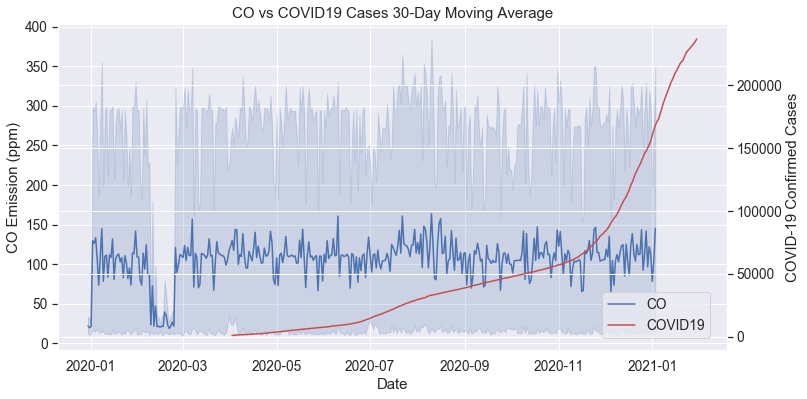

In [24]:
data = df.loc[df['City'] == 'Los Angeles']
data['Date'] = pd.to_datetime(data['Date'])
data['Moving Average'] = data['median'].rolling(window=30, center=True).mean()
data = data[data['Moving Average'].notna()]
data = data.sort_values(by='Date')

# line plot
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()
title = 'CO vs COVID19 Cases 30-Day Moving Average'
sns.lineplot(data=data, x='Date', y='Moving Average', ax=ax1, color='b', label='CO').set_title(title)
sns.lineplot(data=covid, x='date', y='totalcountconfirmed', ax=ax2, color='r', label='COVID19')
ax1.set_ylabel('CO Emission (ppm)')
ax2.set_ylabel('COVID-19 Confirmed Cases')
fig.legend(loc='lower right', bbox_to_anchor=(0.83, 0.125))
ax1.get_legend().remove()
ax2.get_legend().remove()
plt.show()

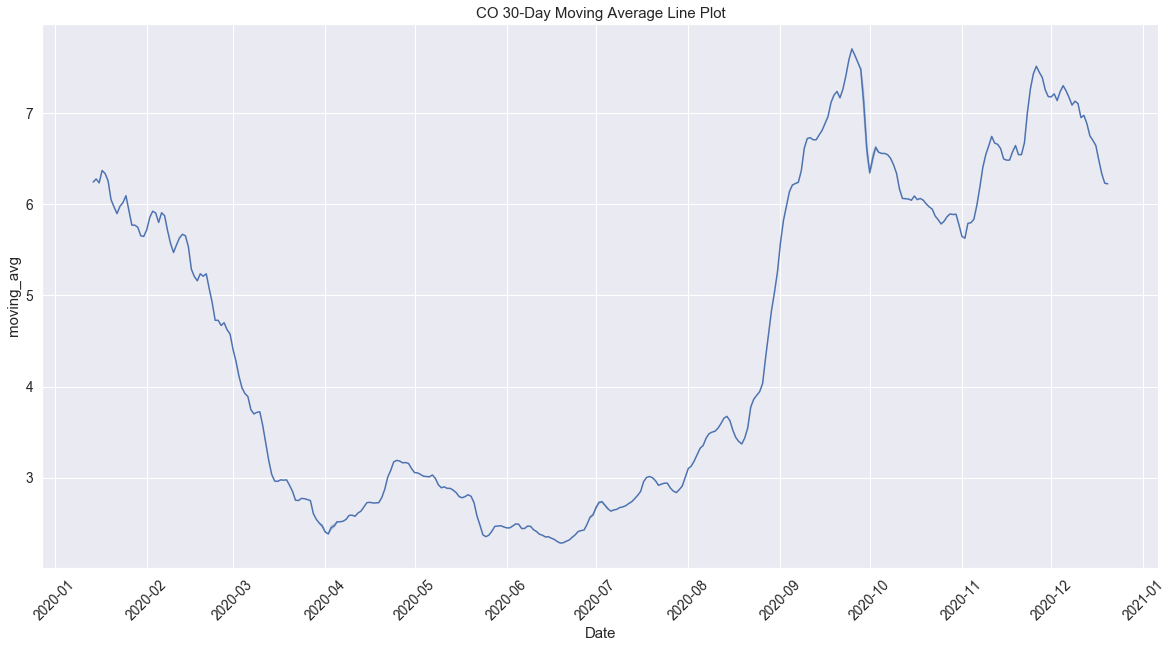

In [22]:
plt.figure(figsize=(20,10))
sns.lineplot(data=test_la, x='Date', y='moving_avg').set_title('CO {}-Day Moving Average Line Plot'.format(30))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.regplot(data=test_sd, x="date_index", y="moving_avg").set_title('CO {}-Day Moving Average Regression Plot'.format(30))
plt.xticks(rotation=45)
plt.show()

In [ ]:
# for name in sd['Specie'].unique():
#     sns.lineplot(data=sd.loc[sd['Specie'] == name].sort_values(by = 'Date'), x='Date', y='median').set_title(name)
#     plt.show()